In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

(a) Download the banknote authentication Data Set from: https://archive.ics.uci.edu/ml/datasets/banknote+authentication. 
Choose 472 data points randomly as the test set. This is a binary classification problem.

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
X = df.loc[:,df.columns[df.columns!='class']]
y = df.loc[:,'class']

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=472, random_state=0)

### Passive Learning

(b) Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.

Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the penalty parameter using 10-fold cross validation.1 Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning.

In [6]:
parameters = {'C':[0.001,0.01,0.05,0.1,0.5,1,5,10,100]}

avg_test_errors = []

for i in range(0,50):
    
    train = pd.DataFrame()

    train_full = pd.concat([X_train_full,y_train_full],axis=1)

    test_errors = []

    for j in range(0,90):

        train_sample = train_full.sample(n=10,replace=False)

        train = pd.concat([train,train_sample], axis = 0)

        train_full.drop(index=train_sample.index.tolist(),inplace=True)

        X_train = train.loc[:,train.columns[train.columns != 'class']]
        y_train = train.loc[:,'class']

        svc = LinearSVC(penalty='l1',dual=False)
        
        #10-fold cross validation for the selected parameters
        clf = GridSearchCV(estimator=svc, param_grid=parameters,cv=KFold(10),refit=True)
        clf.fit(X_train, y_train)
        
        #Predict using the best estimator from GridSearchCV - Using Refit = True
        predicted = clf.predict(X_test)
        actual = np.array(y_test)
        cm = confusion_matrix(actual,predicted)

        test_error = float(cm[0][1] + cm[1][0])/472.0

        test_errors.append(np.round(test_error,2))
    
    avg_test_errors.append(test_errors)

In [7]:
a = np.array(avg_test_errors)

In [8]:
i_avg = []
for i in range(0,90):
    s = 0
    for j in range(0,50):
        s = s + a[j][i]
    i_avg.append(np.round(float(s)/50.0,2))

### Active Learning

(c) Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the parameters of the SVM with 10-fold cross validation. Choose the 10 closest data points in the training set to the margin of the SVM and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool.Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning.

In [10]:
parameters = {'C':[0.001,0.01,0.05,0.1,0.5,1,5,10,100]}

avg_test_errors = []

for i in range(0,50):
    
    train = pd.DataFrame()

    train_full = pd.concat([X_train_full,y_train_full],axis=1)

    test_errors = []

    for j in range(0,90):
        
        if j == 0:
            train_sample = train_full.sample(n=10,replace=False)
        else:
            X_temp = train_full[train_full.columns[train_full.columns!='class']]
            train_sample = train_full.loc[np.abs(clf.decision_function(X_temp)).argsort()[0:10].tolist(),:]

        train = pd.concat([train,train_sample], axis = 0)
        train.reset_index(drop=True,inplace=True)

        train_full.drop(index=train_sample.index.tolist(),inplace=True)
        train_full.reset_index(drop=True,inplace=True)

        X_train = train.loc[:,train.columns[train.columns != 'class']]
        y_train = train.loc[:,'class']

        svc = LinearSVC(penalty='l1',dual=False)
        
        #10-fold cross validation for the selected parameters
        clf = GridSearchCV(estimator=svc, param_grid=parameters,cv=KFold(10),refit=True)
        clf.fit(X_train, y_train)
        
        #Predict using the best estimator from GridSearchCV - Using Refit = True
        predicted = clf.predict(X_test)
        actual = np.array(y_test)
        cm = confusion_matrix(actual,predicted)

        test_error = float(cm[0][1] + cm[1][0])/472.0

        test_errors.append(np.round(test_error,2))
    
    avg_test_errors.append(test_errors)

In [11]:
a = np.array(avg_test_errors)

In [12]:
ii_avg = []
for i in range(0,90):
    s = 0
    for j in range(0,50):
        s = s + a[j][i]
    ii_avg.append(np.round(float(s)/50.0,2))

### Monte-Carlo Simulation

(d) Average the test errors for the incrementally trained 90 SVMs in 1(b)i and1(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions.

In [52]:
a = pd.DataFrame({'Training_Instances': range(10,910,10),'Passive_Learning': i_avg, 'Active_Learning': ii_avg})

In [53]:
a.index = a['Training_Instances']
a = a[['Training_Instances','Active_Learning','Passive_Learning']]
del a['Training_Instances']

Text(0,0.5,u'Average Test Error')

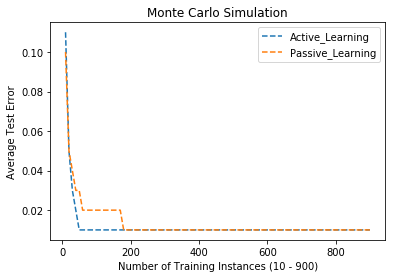

In [54]:
ax = a.plot(style='--',title='Monte Carlo Simulation')
ax.set_xlabel("Number of Training Instances (10 - 900)")
ax.set_ylabel("Average Test Error")

The average test error for Active Learning goes down quicker as compared to Passive Learning. Active Learning gives a better result.